In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import cv2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

---
# Часть 1: Свертки

## Реализация
**Свертка изображений** — это математическая операция, которая позволяет применять ядро (или фильтр) к каждому пикселю изображения, чтобы получить новое изображение с измененными свойствами.

**Ядро свертки**  — это матрица коэффициентов, которая перемещается по изображению с определенным шагом (шаг свертки).

В этом разделе вам необходимо реализовать две версии свертки:
- `conv_nested`
- `conv_fast`

Сначала запустите нижеуказанную кодовую ячейку, чтобы загрузить изображение для работы.

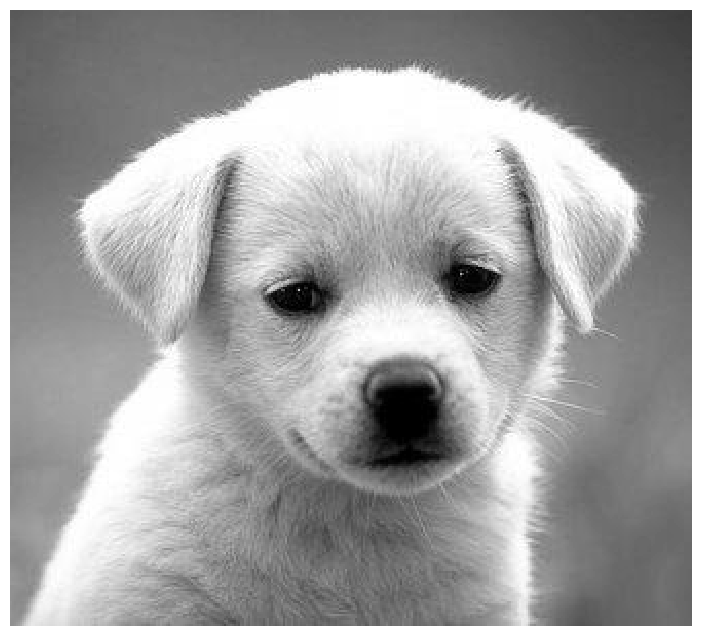

In [3]:
# Open image as grayscale
img = cv2.imread('img/dog.jpg', 0)

# Show image
plt.imshow(img)
plt.axis('off')
plt.show()

Теперь реализуйте функцию **`conv_nested`** в **`filters.py`**. Это наивная реализация convolution, использующая 4 вложенных for-loops. В качестве входа и выхода она берет изображение $f$ и ядро $h$, которое имеет ту же форму, что и входное изображение. Запуск этой реализации должен занять несколько секунд.

Сначала протестируем вашу функцию `conv_nested` на простом входе.

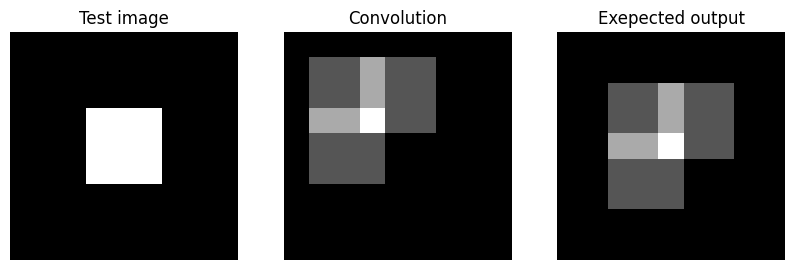

In [4]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE
def conv_nested(image, kernel):
    """A naive implementation of convolution filter.

    This is a naive implementation of convolution using 4 nested for-loops.
    This function computes convolution of an image with a kernel and outputs
    the result that has the same shape as the input image.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    ### YOUR CODE HERE
    kernel = np.flipud(kernel)
    kernel = np.fliplr(kernel)
    start_i = 0
    start_j = 0
    finish_i = Hi - Hk
    finish_j = Wi - Wk
    for i in range(start_i, finish_i):
        for j in range(start_j, finish_j):
            ker_sum = 0
            for k in range(Hk):
                for n in range(Wk):
                    ker_sum += image[i + k][j + n] * kernel[k][n]
            out[i, j] = ker_sum
    ### END YOUR CODE

    return out


# Simple convolution kernel.
kernel = np.array(
[
    [1,0,1],
    [0,0,0],
    [1,0,0]
])

# Create a test image: a white square in the middle
test_img = np.zeros((9, 9))
test_img[3:6, 3:6] = 1

# Run your conv_nested function on the test image
test_output = conv_nested(test_img, kernel)

# Build the expected output
expected_output = np.zeros((9, 9))
expected_output[2:7, 2:7] = 1
expected_output[5:, 5:] = 0
expected_output[4, 2:5] = 2
expected_output[2:5, 4] = 2
expected_output[4, 4] = 3

# Plot the test image
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title('Test image')
plt.axis('off')

# Plot your convolved image
plt.subplot(1,3,2)
plt.imshow(test_output)
plt.title('Convolution')
plt.axis('off')

# Plot the exepected output
plt.subplot(1,3,3)
plt.imshow(expected_output)
plt.title('Exepected output')
plt.axis('off')
plt.show()

Теперь давайте протестируем вашу функцию `conv_nested` на реальном изображении.

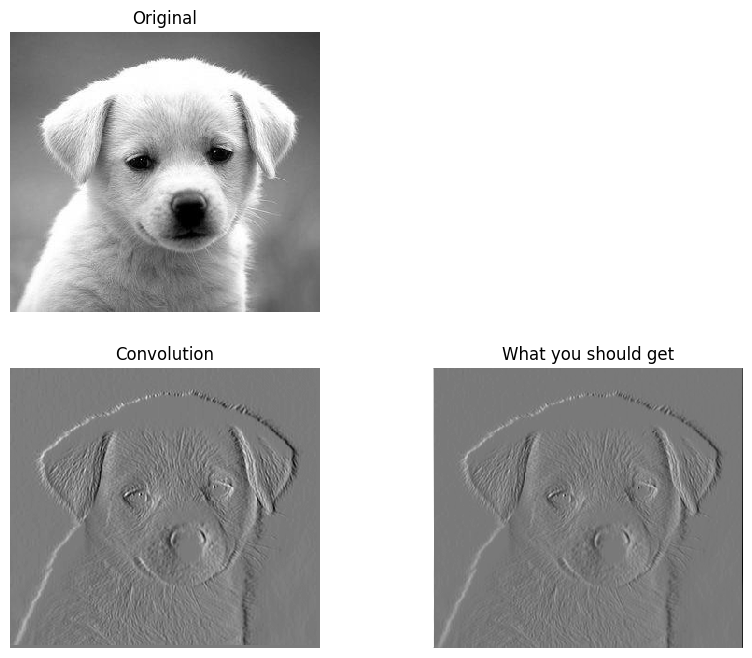

In [6]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE
def conv_nested(image, kernel):
    """A naive implementation of convolution filter.

    This is a naive implementation of convolution using 4 nested for-loops.
    This function computes convolution of an image with a kernel and outputs
    the result that has the same shape as the input image.

    Args:
        image: numpy array of shape (Hi, Wi).
        kernel: numpy array of shape (Hk, Wk).

    Returns:
        out: numpy array of shape (Hi, Wi).
    """
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    out = np.zeros((Hi, Wi))

    ### YOUR CODE HERE
    kernel = np.flipud(kernel)
    kernel = np.fliplr(kernel)
    start_i = 0
    start_j = 0
    finish_i = Hi - Hk
    finish_j = Wi - Wk
    for i in range(start_i, finish_i):
        for j in range(start_j, finish_j):
            ker_sum = 0
            for k in range(Hk):
                for n in range(Wk):
                    ker_sum += image[i + k][j + n] * kernel[k][n]
            out[i, j] = ker_sum
    ### END YOUR CODE

    return out


# Simple convolution kernel.
# Feel free to change the kernel to see different outputs.
kernel = np.array(
[
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])

out = conv_nested(img, kernel)

# Plot original image
plt.subplot(221), plt.imshow(img), plt.title('Original'), plt.axis('off')

# Plot your convolved image
plt.subplot(223), plt.imshow(out), plt.title('Convolution'), plt.axis('off')

# Plot what you should get
solution_img = cv2.imread('img/convoluted_dog.jpg', 0)
plt.subplot(224), plt.imshow(solution_img), plt.title('What you should get'), plt.axis('off')

plt.show()

Реализуем более эффективный вариант свертки с использованием операций с массивами в numpy. Cвертку можно рассматривать как скользящее окно, которое вычисляет сумму значений пикселей, взвешенных перевернутым ядром. Более быстрая версия: 
1) будет иметь нулевое изображение;
2) перевернёт ядро по горизонтали и вертикали;
3) вычислит взвешенную сумму окрестностей в каждом пикселе.

Во-первых, реализуйте функцию **`zero_pad`** в **`filters.py`**, которая будет дополнять границы изображения.

(380, 372)


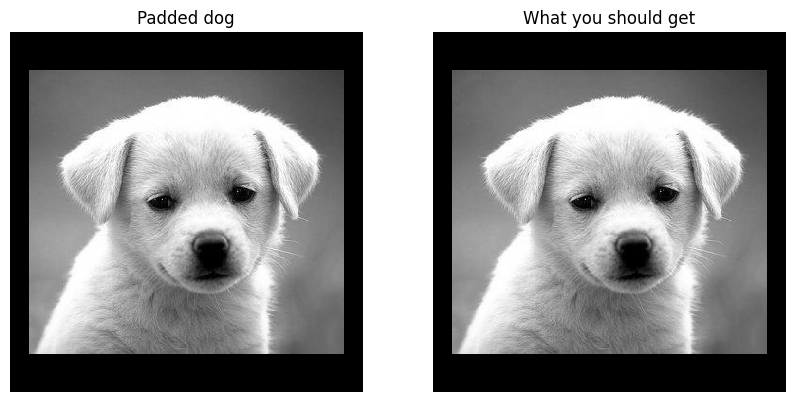

In [8]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE
def zero_pad(image, pad_height, pad_width):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_height = 1, pad_width = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W).
        pad_width: width of the zero padding (left and right padding).
        pad_height: height of the zero padding (bottom and top padding).

    Returns:
        out: numpy array of shape (H+2*pad_height, W+2*pad_width).
    """

    H, W = image.shape

    ### YOUR CODE HERE
    out = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), "constant", constant_values=(0,0))
    ### END YOUR CODE
    return out


pad_width = 20 # width of the padding on the left and right
pad_height = 40 # height of the padding on the top and bottom

padded_img = zero_pad(img, pad_height, pad_width)
print(padded_img.shape)


# Plot your padded dog
plt.subplot(121), plt.imshow(padded_img), plt.title('Padded dog'), plt.axis('off')

# Plot what you should get
solution_img = cv2.imread('img/padded_dog.jpg', 0)
plt.subplot(122), plt.imshow(solution_img), plt.title('What you should get'), plt.axis('off')

plt.show()

Далее, выполните функцию **`conv_fast`** в **`filters.py`** с помощью `zero_pad`. Запустите код ниже, чтобы сравнить результаты по двум реализациям. `conv_fast` должна работать значительно быстрее, чем `conv_nested`.

conv_nested: took 0.000996 seconds.
conv_fast: took 0.000000 seconds.


(-0.5, 331.5, 299.5, -0.5)

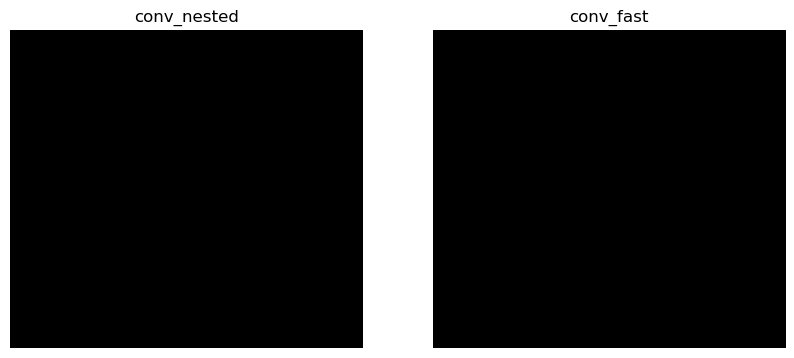

In [7]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE

t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_nested = conv_nested(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_nested: took %f seconds." % (t2 - t1))
print("conv_fast: took %f seconds." % (t1 - t0))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_nested)
plt.title('conv_nested')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

### Задание со звездочкой

Разработайте более быструю версию свертки и реализуйте **`conv_faster`** в **`filters.py`**. Задание со звёздочкой считается выполненным, если `conv_faster` будет работать быстрее (с достаточным запасом), чем `conv_fast` **и** выдаст тот же результат.

conv_fast: took 0.000998 seconds.
conv_faster: took 0.000000 seconds.


(-0.5, 331.5, 299.5, -0.5)

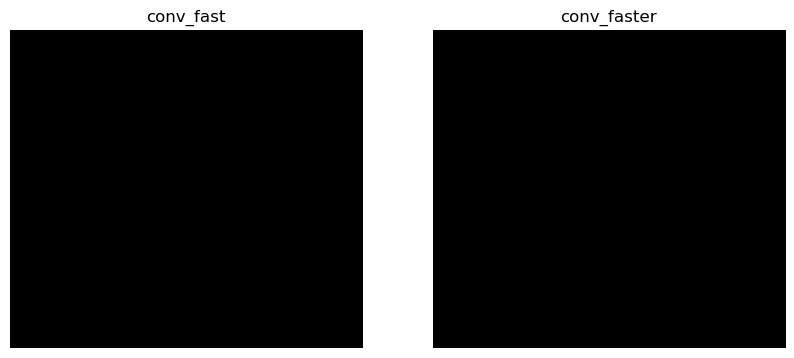

In [8]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE

t0 = time()
out_fast = conv_fast(img, kernel)
t1 = time()
out_faster = conv_faster(img, kernel)
t2 = time()

# Compare the running time of the two implementations
print("conv_fast: took %f seconds." % (t1 - t0))
print("conv_faster: took %f seconds." % (t2 - t1))

# Plot conv_nested output
plt.subplot(1,2,1)
plt.imshow(out_fast)
plt.title('conv_fast')
plt.axis('off')

# Plot conv_fast output
plt.subplot(1,2,2)
plt.imshow(out_faster)
plt.title('conv_faster')
plt.axis('off')

---
# Часть 2: Кросс-корреляция

Кросс-корреляция двух 2D сигналов $f$ и $g$ определяется следующим образом:
$$(f\star{g})[m,n]=\sum_{i=-\infty}^\infty\sum_{j=-\infty}^\infty f[i,j]\cdot g[m-i,n-j]$$

## Проверка шаблона с помощью кросс-корреляцией 

Предположим, что ты продавщица в продуктовом магазине. Одна из ваших обязанностей - периодически проверять полки и складировать их всякий раз, когда есть распроданные товары. Вы устали от этой кропотливой работы и решили построить систему компьютерного зрения, которая отслеживает предметы на полке.

К счастью, вы узнали, что для сопоставления шаблонов можно использовать кросс-корреляцию: шаблон $g$ умножается на регионы с большим изображением $f$, чтобы измерить, насколько каждый регион похож на шаблон.

Шаблон товара (`template.jpg`) и изображение полки (`shelf.jpg`) предоставляются. Мы будем использовать кросс-корреляцию, чтобы найти товар на полке.

Реализуйте функцию **`cross_correlation`** в **`filters.py`** и запустите код ниже.

*- Подсказка: Вы можете использовать функцию `conv_fast`, которую вы реализовали в предыдущем вопросе.

**Если ваша реализация корректна, то вы должны увидеть синий крест по центру от правильной коробки с хлопьями**.

In [9]:
# Load template and image in grayscale
img = cv2.imread('img/shelf.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_grey = cv2.imread('img/shelf.jpg', 0)
temp = cv2.imread('img/template.jpg')
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
temp_grey = cv2.imread('img/template.jpg', 0)

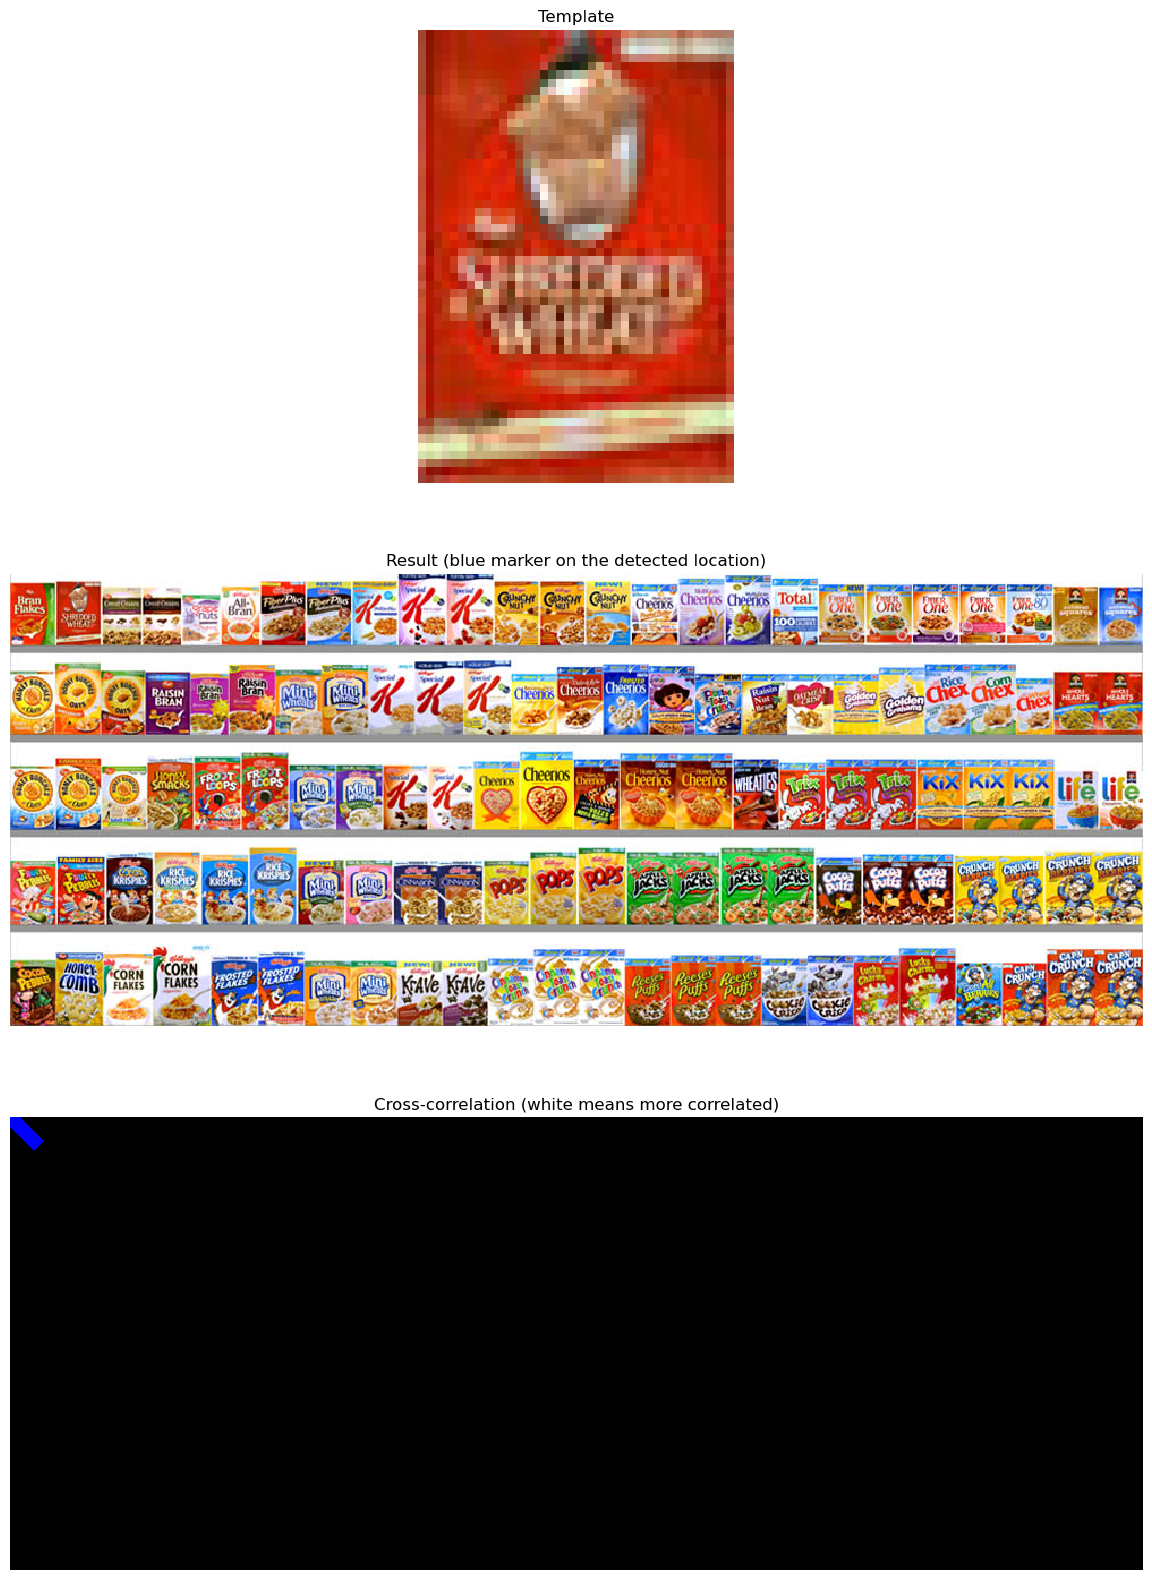

In [10]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE

# Perform cross-correlation between the image and the template
out = cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(25, 20))

# Display product template
plt.subplot(311), plt.imshow(temp), plt.title('Template'), plt.axis('off') 

# Display image
plt.subplot(312), plt.imshow(img), plt.title('Result (blue marker on the detected location)'), plt.axis('off')

# Display cross-correlation output
plt.subplot(313), plt.imshow(out), plt.title('Cross-correlation (white means more correlated)'), plt.axis('off')

# Draw marker at detected location
plt.plot(x, y, 'bx', ms=40, mew=10)

plt.show()

---
## Нулевая кросс-корреляция

Решение этой проблемы заключается в вычитании среднего значения шаблона так, чтобы оно имело нулевое среднее значение.

Реализуйте функцию **`zero_mean_cross_correlation`** в файле **`filters.py`** и запустите код ниже.

**Если ваша реализация корректна, то вы должны увидеть синий крест по центру от правильной коробки с хлопьями**.

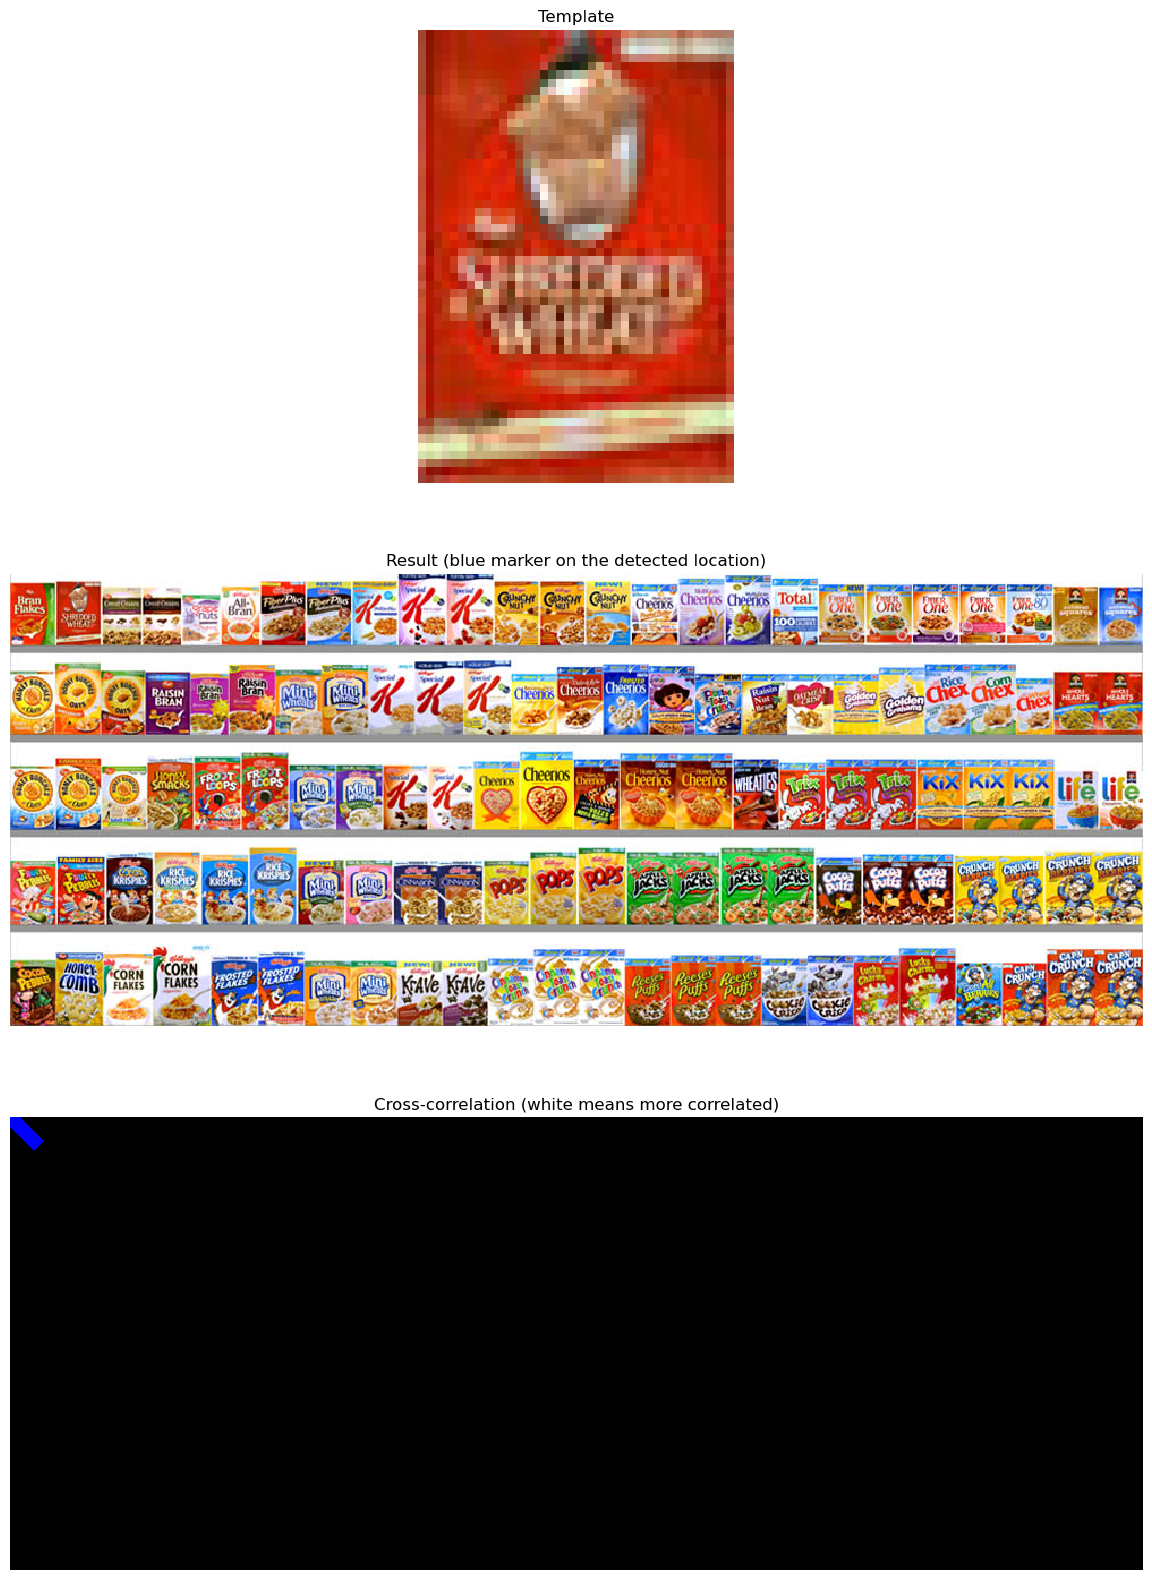

In [11]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE

# Perform cross-correlation between the image and the template
out = zero_mean_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)

plt.figure(figsize=(30, 20))

# Display product template
plt.subplot(311), plt.imshow(temp), plt.title('Template'), plt.axis('off')

# Display image
plt.subplot(312), plt.imshow(img), plt.title('Result (blue marker on the detected location)'), plt.axis('off')

# Display cross-correlation output
plt.subplot(313), plt.imshow(out), plt.title('Cross-correlation (white means more correlated)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'bx', ms=40, mew=10)

plt.show()

---
## Нормализованная кросс-корреляция
Однажды свет возле полки погаснет, и устройство слежения за продуктами начнет работать неисправно. `zero_mean_cross_correlation` не устойчива к изменению состояния освещения.

Решение заключается в нормализации пикселей изображения и шаблона на каждом шаге перед их сравнением. Это называется **нормализованной кросс-корреляцией**.

Математическим определением нормализованной кросс-корреляции является $f$ и шаблон $g$:
$$(f\star{g})[m,n]=\sum_{i,j} \frac{f[i,j]-\overline{f_{m,n}}}{\sigma_{f_{m,n}}} \cdot \frac{g[i-m,j-n]-\overline{g}}{\sigma_g}$$

Где:
- $f_{m,n}$ - это патч-изображение в позиции $(m,n)$
- $\overline{f_{m,n}}$ - это среднее значение изображения патча $f_{m,n}$.
- $\sigma_{f_{m,n}}$ - стандартное отклонение изображения патча $f_{m,n}$ 
- $\overline{g}$ - это среднее значение шаблона $g$.
- $\sigma_g$ - стандартное отклонение шаблона $g$.

Реализуйте функцию **`normalized_cross_correlation`** в файле **`filters.py`** и запустите код ниже.

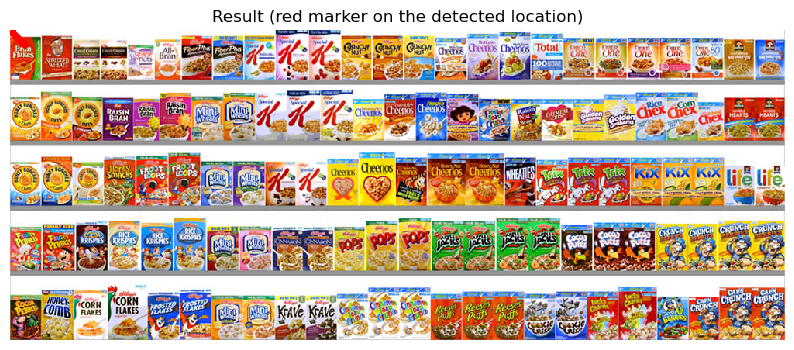

In [16]:
# TODO: загрузите вашу реализацию из filters.py
# YOUR CODE HERE

# Perform normalized cross-correlation between the image and the template
out = normalized_cross_correlation(img_grey, temp_grey)

# Find the location with maximum similarity
y, x = np.unravel_index(out.argmax(), out.shape)


plt.figure(figsize=(10, 5))

# Display image
plt.imshow(img), plt.title('Result (red marker on the detected location)'), plt.axis('off')

# Draw marker at detcted location
plt.plot(x, y, 'rx', ms=25, mew=5)
plt.show()